# RNN-LSTM Classifier

- **Authors:** Guilherme Magalhães, João Sousa, João Baptista
- **University:** Faculty of Sciences of University of Porto
- **Course:** Machine Learning II (CC3043)

### Sound Classification Problem
In the context of the Machine Learning II course, we were asked to develop deep learning classifiers for urban sound data. The data used belongs to the [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html) dataset, which cointains 8732 labeled urban sound excerpts of duration less than or equal to 4 seconds. These sounds are labelled according to the following 10 classes:

- 0 = air_conditioner
- 1 = car_horn
- 2 = children_playing
- 3 = dog_bark
- 4 = drilling
- 5 = engine_idling
- 6 = gun_shot
- 7 = jackhammer
- 8 = siren
- 9 = street_music

### Developed Classifier
In this notebook, we implemented a Long-Short Term Memory (LSTM) version of a Recurrent Neural Network (RNN). Considering that a RNN is a neural network used for processing sequencial data, it made sense that we implemented it given the context of the project. 

However, a traditional RNN has a single hidden state that is passed through time, which can make it difficult for the network to learn long-term dependencies. LSTMs model address this problem by introducing a memory cell, which is a container that can hold information for an extended period of time.

LSTM architectures are capable of learning long-term dependencies in sequential data, which makes them well-suited for tasks such as language translation, speech recognition, and time series forecasting.

#### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import librosa
import pickle
import gc
import os
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Flatten
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


#### Saving and Loading Data

Function using *pickle* library to save and load data from the disk.

In [2]:
def save_pkl(data, path):
    try:
        with open(path, "wb") as saved_data:
            pickle.dump(data, saved_data)
    except:
        print('Fail to save data')

def load_pkl(path):
    try:
        with open(path, "rb") as loaded_data:
            to_return = pickle.load(loaded_data)
        return to_return
    except:
        print('Fail to load data')
        return None

#### Metadata

First of all, we need to analyse the data. To do so, we load the dataset's folder that contains a *.csv* file regarding its metadata:

In [3]:
df = pd.read_csv("../UrbanSound8K/metadata/UrbanSound8K.csv") 
df.head() 

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Now, our pandas dataframe contains helpful information regarding all of the sounds from the dataset. Let's use it to see the target classes distribution:

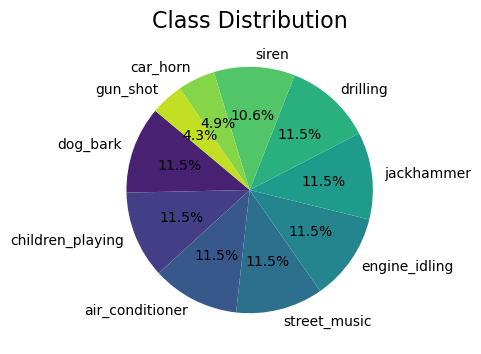

In [4]:
class_counts = df['class'].value_counts()
plt.figure(figsize=(4, 4))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", n_colors=10))
plt.title("Class Distribution", fontsize=16)
plt.show()

#### Feature Extraction and Pre-Processing

Considering that providing the model with the raw data would have negative consequences on the model's performance, we implemented steps for **Feature Exctraction** and **Data Pre-Processing**.

##### Feature Exctraction - MFCC

For the feature extraction step, we compared the performance of our model using Log-Scaled Mel Spectograms and MFCC's. After that, we concluded that MFCC's had a more significant impact on the performance of our LSTM model. 

MFCC stands for Mel-Frequency Cepstral Coefficients. Essentially, it’s a way to represent the short-term power spectrum of a sound which helps machines understand and process sounds more effectively. MFCC enables computers to discern between sounds. In audio classification applications where computers must translate spoken words into text this code is especially helpful.

Here is an example of a MFCC:

107228-5-0-0.wav


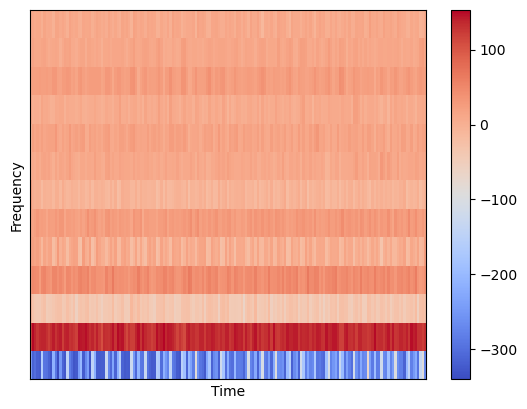

In [5]:
filename = df.slice_file_name[500] # select random file
fold = df.fold[500]
print(filename)
path = '../UrbanSound8K/audio/fold' + str(fold) + '/' + str(filename)
audio, sr = librosa.load(path, sr = 44100)
mfcc = librosa.feature.mfcc(y = audio, n_mfcc = 13, hop_length = 1024)
librosa.display.specshow(mfcc, sr = sr, hop_length = 1024)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

To extract all of the MFCC's, we used the *librosa.feature.mfcc* method. After that, we normalized all the mfcc's using the min-max scaling and extracted the label of each audio file. For this model, we decided to use a hop_length of 1024 and a sample rate of 44100 to ensure a better sound quality.

Here is the function:

In [6]:
def feature_extraction(dataframe, audios):
    mfcc_coeficients = []
    labels = []

    for index in range(len(audios)):
        try:
            file_name =audios[index][0]
            if file_name:
                row = dataframe.loc[dataframe["slice_file_name"] == file_name]
                if not row.empty:
                    label = row.iloc[0,6] #get the corresponding label
                    # mfcc extraction
                    mfcc = librosa.feature.mfcc(
                        y = audios[index][1],
                        n_mfcc = 13, 
                        hop_length = 1024  
                    )
                    # mfcc normalization
                    # mfcc = (mfcc - np.min(mfcc)) /( np.max(mfcc)- np.min(mfcc))
                    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
                    mfcc_coeficients.append(mfcc)
                    labels.append(label)
        except Exception:
            print(f"Error in processig file {audios[index][0]}: {Exception}")

    mfcc_coeficients = np.array(mfcc_coeficients)
    mfcc_coeficients = mfcc_coeficients.transpose(0,2,1) # transpose so it matches the input_shape of the LSTM
    labels = np.array(labels)
    return mfcc_coeficients, labels

#### Data Pre-Processing

Considering that the audio files in our dataset have different lengths, we implemented the following function that uses *librosa* methods to perform audio pre-processing by loading files, resampling them to a fixed length (4 seconds * 44100 Hz), normalizing their amplitude and ensuring a consistent duration through padding. This way, it prepares the audio data for the machine learning task we are developing.

In [7]:
def pre_processing(path, duration = 4, sr = 44100):
    files = librosa.util.find_files(path)
    data = []
    target_length = duration * sr
    for index, file_path in enumerate(files):
        try:
            audio, _ = librosa.load(file_path, sr=sr, mono=True)

            audio = librosa.util.fix_length(audio, size = target_length)
            audio = librosa.util.normalize(audio)

            file_name = os.path.basename(file_path)
            data.append([file_name, audio])
        
        except Exception as e:
            print(f"Error in processig file {file_path}: {e}")

    return data

In [8]:
fold_paths = ["../UrbanSound8K/audio/fold1",
              "../UrbanSound8K/audio/fold2",
              "../UrbanSound8K/audio/fold3",
              "../UrbanSound8K/audio/fold4",
              "../UrbanSound8K/audio/fold5",
              "../UrbanSound8K/audio/fold6",
              "../UrbanSound8K/audio/fold7",
              "../UrbanSound8K/audio/fold8",
              "../UrbanSound8K/audio/fold9",
              "../UrbanSound8K/audio/fold10"]

Firstly, with our *feature_extraction* and *pre_processing* functions defined, we used them to perform the feature extraction and data pre-processing of our data for each fold.

Secondly, the target variables were *One-Hot Encoded*, which means that the we now have 10 target columns, one for each possible class.

After that, we analysed the features and labels shapes for each fold and we saved the data using the save_pkl function

In [9]:
features = np.empty((10,), dtype=object)
label = np.empty((10,), dtype=object)

for i, fold in enumerate(fold_paths):
    print(f"Processing Fold Number {i+1}")
    audio_data = pre_processing(fold)

    mfcc, labels = feature_extraction(df, audio_data)
    # one-hot encodding of the labels
    encoded_labels = np.zeros((len(labels), 10))
    encoded_labels[np.arange(len(labels)), labels] = 1
    
    features[i] = mfcc
    label[i] = encoded_labels
    # analysing the shape
    print("Features Shape: ",features[i].shape)
    print("Labels Shape: ",label[i].shape,"\n")
    
    del mfcc
    del labels
    del encoded_labels
    gc.collect() # saving memory

# saving the data using pickle function defined in the beggining of the notebook
save_pkl(features,"data/features_rnn.pkl")
save_pkl(label,"data/labels_rnn.pkl")


Processing Fold Number 1
Features Shape:  (873, 173, 13)
Labels Shape:  (873, 10) 

Processing Fold Number 2
Features Shape:  (888, 173, 13)
Labels Shape:  (888, 10) 

Processing Fold Number 3
Features Shape:  (925, 173, 13)
Labels Shape:  (925, 10) 

Processing Fold Number 4
Features Shape:  (990, 173, 13)
Labels Shape:  (990, 10) 

Processing Fold Number 5
Features Shape:  (936, 173, 13)
Labels Shape:  (936, 10) 

Processing Fold Number 6
Features Shape:  (823, 173, 13)
Labels Shape:  (823, 10) 

Processing Fold Number 7
Features Shape:  (838, 173, 13)
Labels Shape:  (838, 10) 

Processing Fold Number 8
Features Shape:  (806, 173, 13)
Labels Shape:  (806, 10) 

Processing Fold Number 9
Features Shape:  (816, 173, 13)
Labels Shape:  (816, 10) 

Processing Fold Number 10
Features Shape:  (837, 173, 13)
Labels Shape:  (837, 10) 



To get further information regarding the dataset, we plotted the class distribution of each fold:

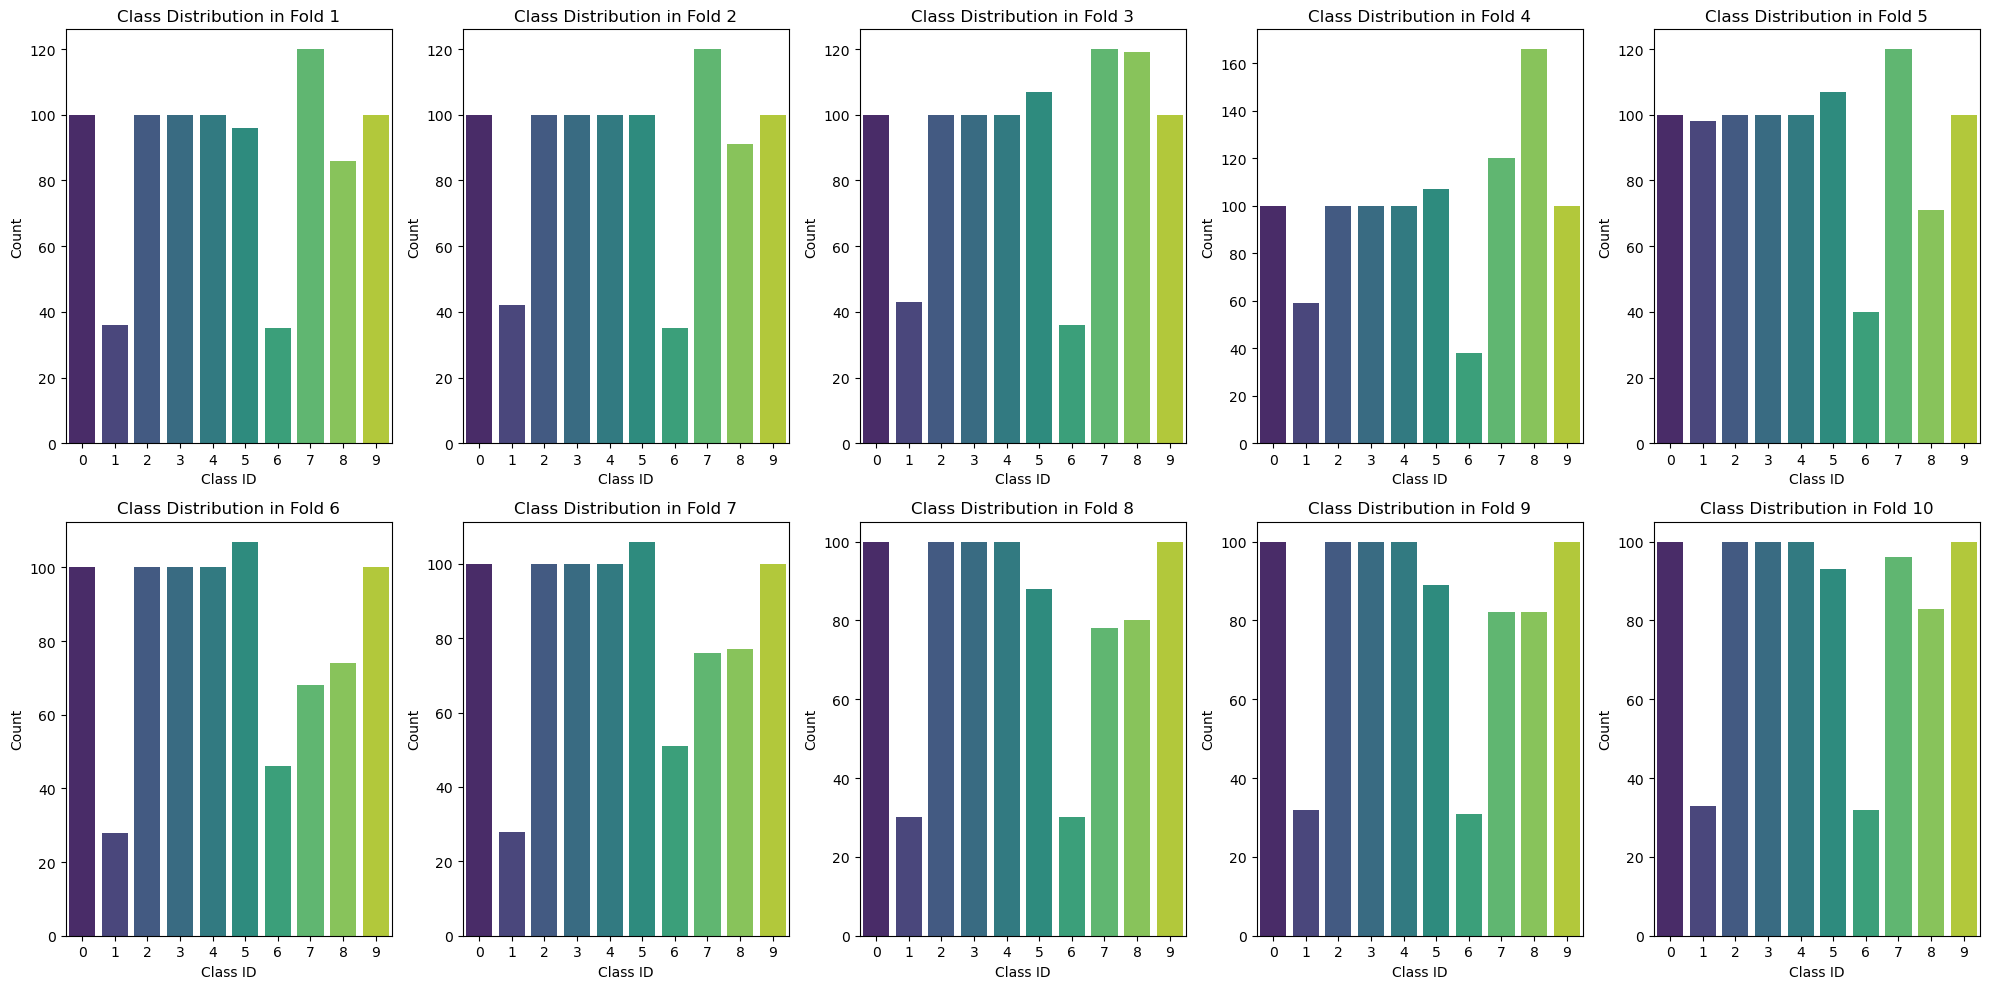

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10)) 
for i, fold_path in enumerate(fold_paths):
    fold_name = os.path.basename(fold_path)  
    fold_number = int(fold_name.replace("fold", ""))
    fold_data = df[df["fold"] == fold_number]  
    class_counts = fold_data["classID"].value_counts().sort_index()  
    ax = axes[i // 5, i % 5]  

    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis", ax=ax)
    ax.set_title(f"Class Distribution in Fold {fold_number}", fontsize=12)
    ax.set_xlabel("Class ID", fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
    ax.set_xticks(range(10))  


plt.tight_layout()
plt.show()

### Model Architecture

Considering that the quest for 

#### 1. Input Layer
- Shape: (x, y) where:
  - x is the number of timesteps (duration * sr // hop_length + 1).
  - y is the number of features per timestep (# of MFCC).
- Purpose: The model expects a sequential input where each timestep represents a feature vector of the audio signal.

#### 2. First LSTM Layer
Description: A LSTM with 128 units.
- Activation: tanh for non-linearity.
- Kernel Initialization: glorot_uniform for balanced weight initialization.
- Output: Produces a sequence of 128 features for each timestep.

#### 3. Second LSTM Layer
Description: Bidirectional LSTM with 64 units.
- Bidirectionality: Processes the sequence in both forward and backward directions to capture dependencies in the audio signal from past and future timesteps.
- Purpose: Further refines temporal features extracted from the first LSTM layer, learning more complex patterns.
- Output: Produces a sequence of 64 features for each timestep.

#### 4. TimeDistributed Dense Layers
Description: Fully connected layers applied independently to each timestep. These layers transform the feature representation at each timestep into higher-level abstractions.
- First Dense Layer:
  - Units: 64 neurons.
  - Activation: TanH
  - Regularization: L2 regularization (0.01) to prevent overfitting.
  - Dropout (0.4): <b>Randomly drops 30% of connections to prevent overfitting.</b>
- Second Dense Layer:
  - Units: 32 neurons.
  - Activation: TanH.
  - Regularization: L2 regularization (0.01).
  - Dropout (0.4).
- Third Dense Layer:
  - Units: 16 neurons.
  - Activation: TanH
  - Regularization: L2 regularization (0.01)
  - Dropout (0.4).
- Fourth Dense Layer:
  - Units: 8 neurons.
  - Activation: Tanh.
  - Regularization: L2 regularization (0.01).
  - Purpose: These layers learn high-level feature transformations for each timestep.

#### 5. Flatten Layer
Description: Flattens the outputs of the TimeDistributed Dense layers into a single vector.
- Purpose: Converts the sequence of features into a 1D vector suitable for final classification.

#### 6. Output Layer
Description: A fully connected Dense layer with 10 neurons.
- Activation: Softmax, which outputs a probability distribution over the 10 sound classes.
- Purpose: Final classification into one of the 10 categories.

In [27]:
def create_model(x, y):
    input_shape = (x,y) # x = time series, y = # of mfcc's
    model = Sequential()
    # LSTM layers
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False, activation='tanh'))

    # Fully connected layers
    model.add((Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))))
    model.add(Dropout(0.3))
    model.add((Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005))))

    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    return model

In [28]:
model = create_model(173, 13)
model.summary()
del model
keras.backend.clear_session()
gc.collect()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 173, 128)       │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 173, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,682 (502.66 KB)

 Trainable params: 128,682 (502.66 KB)

 Non-trainable params: 0 (0.00 B)

0

## Cross Validation

In [ ]:
fold_metrics = []
EPOCHS = 50

sets_treino_val = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,0]] # [set_test,set_val] | 0 = fold1 | 1 = fold2 | ...

for fold in range(10):
    print(f"Fold {fold+1}:")

    X_test, y_test =[], []
    X_val, y_val = [], []
    X_train, y_train = [], []

    # separate the data(folds) in test(1 fold) | validation(1 fold) | train(8 folds)
    for i in range(10):
        if i == sets_treino_val[fold][0]:
            # test_set
            X_test = features[i]
            y_test = label[i]
        elif i == sets_treino_val[fold][1]:
            # set de validacao
            X_val = features[i]
            y_val = label[i]
            
        else:
            # define sets for training
            if len(X_train) == 0:  # inicializar no primeiro fold de treino
                X_train = features[i]
                y_train = label[i]
            else:
                X_train = np.concatenate((X_train, features[i]), axis=0)
                y_train = np.concatenate((y_train, label[i]), axis=0)


    # converter para np array caso ainda nao estejam
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)

    # iniciar o modelo
    model = create_model(173, 13)

    # compilar o modelo com o optimizer Adam
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    # treinar o modelo
    LSTM_model = model.fit(
        X_train, y_train, 
        epochs=EPOCHS,
        batch_size=64, 
        shuffle=False, 
        validation_data=(X_val, y_val)
    )

    # prever no set de test
    y_pred = model.predict(X_test)

    # avaliar o modelo
    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    TestLoss, Testacc = model.evaluate(X_test, y_test)

    # guardar os resultados para o guardar disco/visualizar no futuro
    m_metrics = {
        'loss': TestLoss, 
        'accuracy': Testacc, 
        'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
        'history': model, 
        'history_dict': LSTM_model.history
    }

    fold_metrics.append(m_metrics)

    model.save(f"kfold_metrics_LSTM/model_fold{fold+1}.keras", save_format="keras")
    save_pkl(m_metrics, f"kfold_metrics_LSTM/metrics_fold{fold+1}.pkl")

    # eliminar o modelo para começar de novo para evitar memory leak
    del model
    keras.backend.clear_session()
    gc.collect()

    print("Done.")

Fold 1:
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.1206 - loss: 2.7157 - val_accuracy: 0.1858 - val_loss: 2.3692
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.2055 - loss: 2.3083 - val_accuracy: 0.2173 - val_loss: 2.2374
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.2165 - loss: 2.2073 - val_accuracy: 0.2196 - val_loss: 2.2313
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.2194 - loss: 2.1172 - val_accuracy: 0.2241 - val_loss: 2.1981
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.2119 - loss: 2.0988 - val_accuracy: 0.2106 - val_loss: 2.1758
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.2142 - loss: 2.1056 - val_accuracy: 0.2027 - val_loss: 2.1853
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.2149 - loss: 2.1110 - val_accuracy: 0.1982 - val_loss: 2.0202
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.2211 -

Done.
Fold 2:
Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.1282 - loss: 2.7064 - val_accuracy: 0.2346 - val_loss: 2.3480
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.2090 - loss: 2.3312 - val_accuracy: 0.2584 - val_loss: 2.1961
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.2221 - loss: 2.1930 - val_accuracy: 0.2216 - val_loss: 2.1452
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.2344 - loss: 2.1059 - val_accuracy: 0.2908 - val_loss: 2.0774
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.2401 - loss: 2.0413 - val_accuracy: 0.2973 - val_loss: 2.1606
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.2433 - loss: 2.0019 - val_accuracy: 0.3676 - val_loss: 1.9904
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - accuracy: 0.2729 - loss: 1.9379 - val_accuracy: 0.3005 - val_loss: 2.0128
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.

Done.
Fold 3:
Epoch 1/50


## Plots to analize the classification

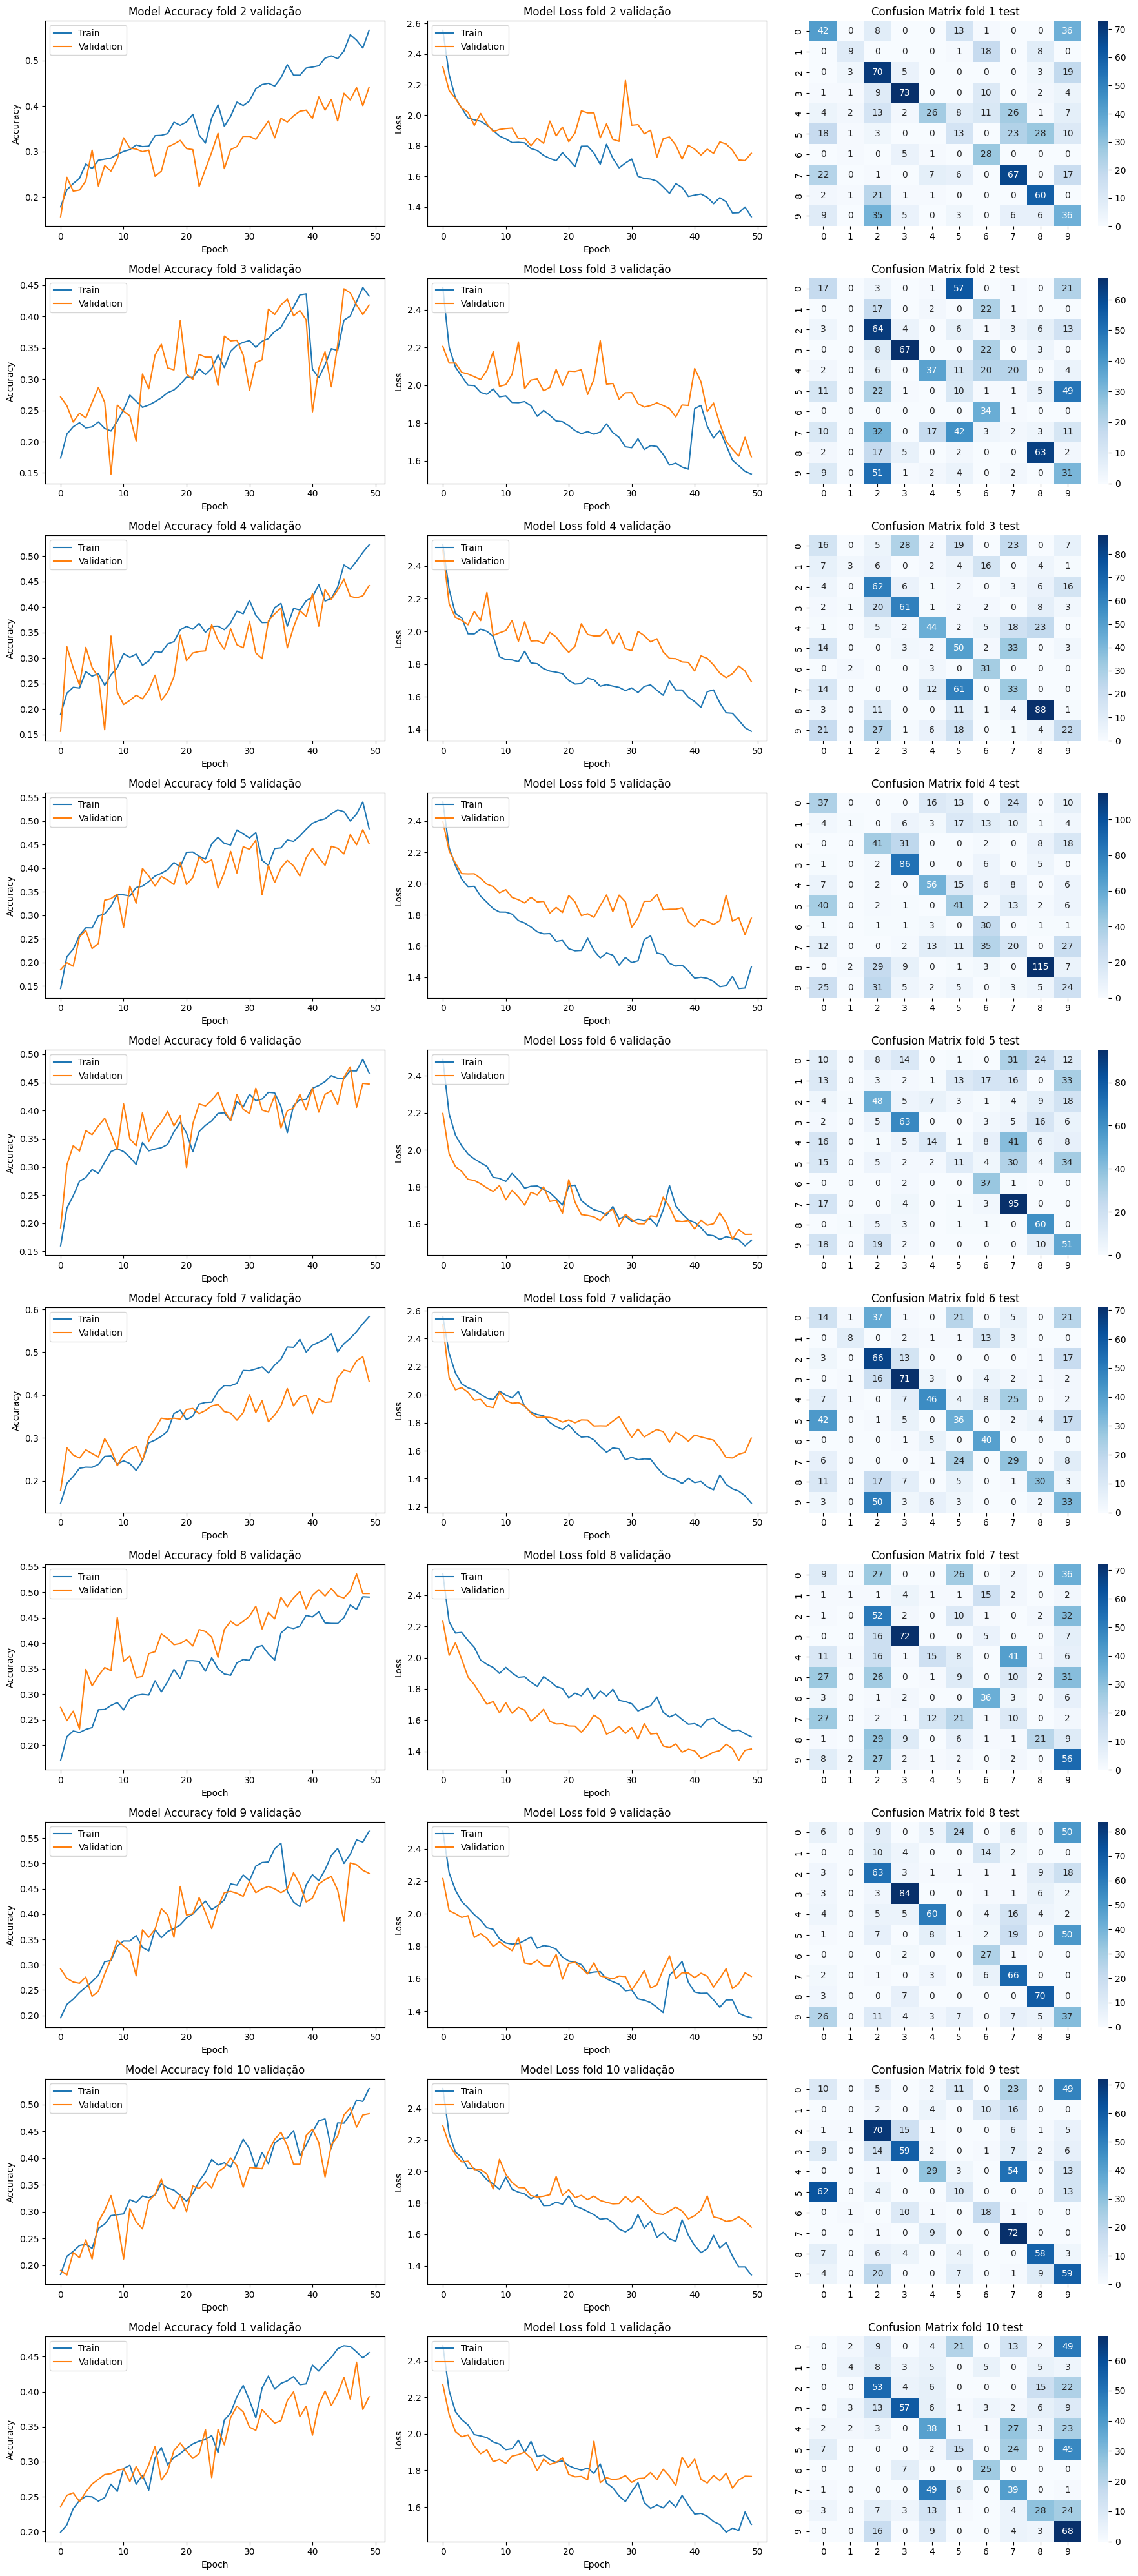

In [44]:
class_labels = [i for i in range(10)]
# Create a 10x3 grid for subplots
fig, axs = plt.subplots(10, 3, figsize=(18, 40))

for i in range(len(fold_metrics)):
    history = fold_metrics[i].get('history_dict')

    # Plot accuracy values
    axs[i,0].plot(history['accuracy'])
    axs[i,0].plot(history['val_accuracy'])
    if i == 9:
        axs[i,0].set_title(f'Model Accuracy fold 1 validação')
    else:    
        axs[i,0].set_title(f'Model Accuracy fold {i+2} validação')
    axs[i,0].set_ylabel('Accuracy')
    axs[i,0].set_xlabel('Epoch')
    axs[i,0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[i,1].plot(history['loss'])
    axs[i,1].plot(history['val_loss'])
    if i == 9:
        axs[i,1].set_title(f'Model Loss fold 1 validação')
    else:    
        axs[i,1].set_title(f'Model Loss fold {i+2} validação')
    axs[i,1].set_ylabel('Loss')
    axs[i,1].set_xlabel('Epoch')
    axs[i,1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = fold_metrics[i].get('confusion_matrix')
    axs[i,2].set_title(f'Confusion Matrix fold {i+1} test')
    axs[i,2].set_xlabel('Predicted')
    axs[i,2].set_ylabel('True')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[i,2])

# Adjust layout
plt.tight_layout()
plt.show()

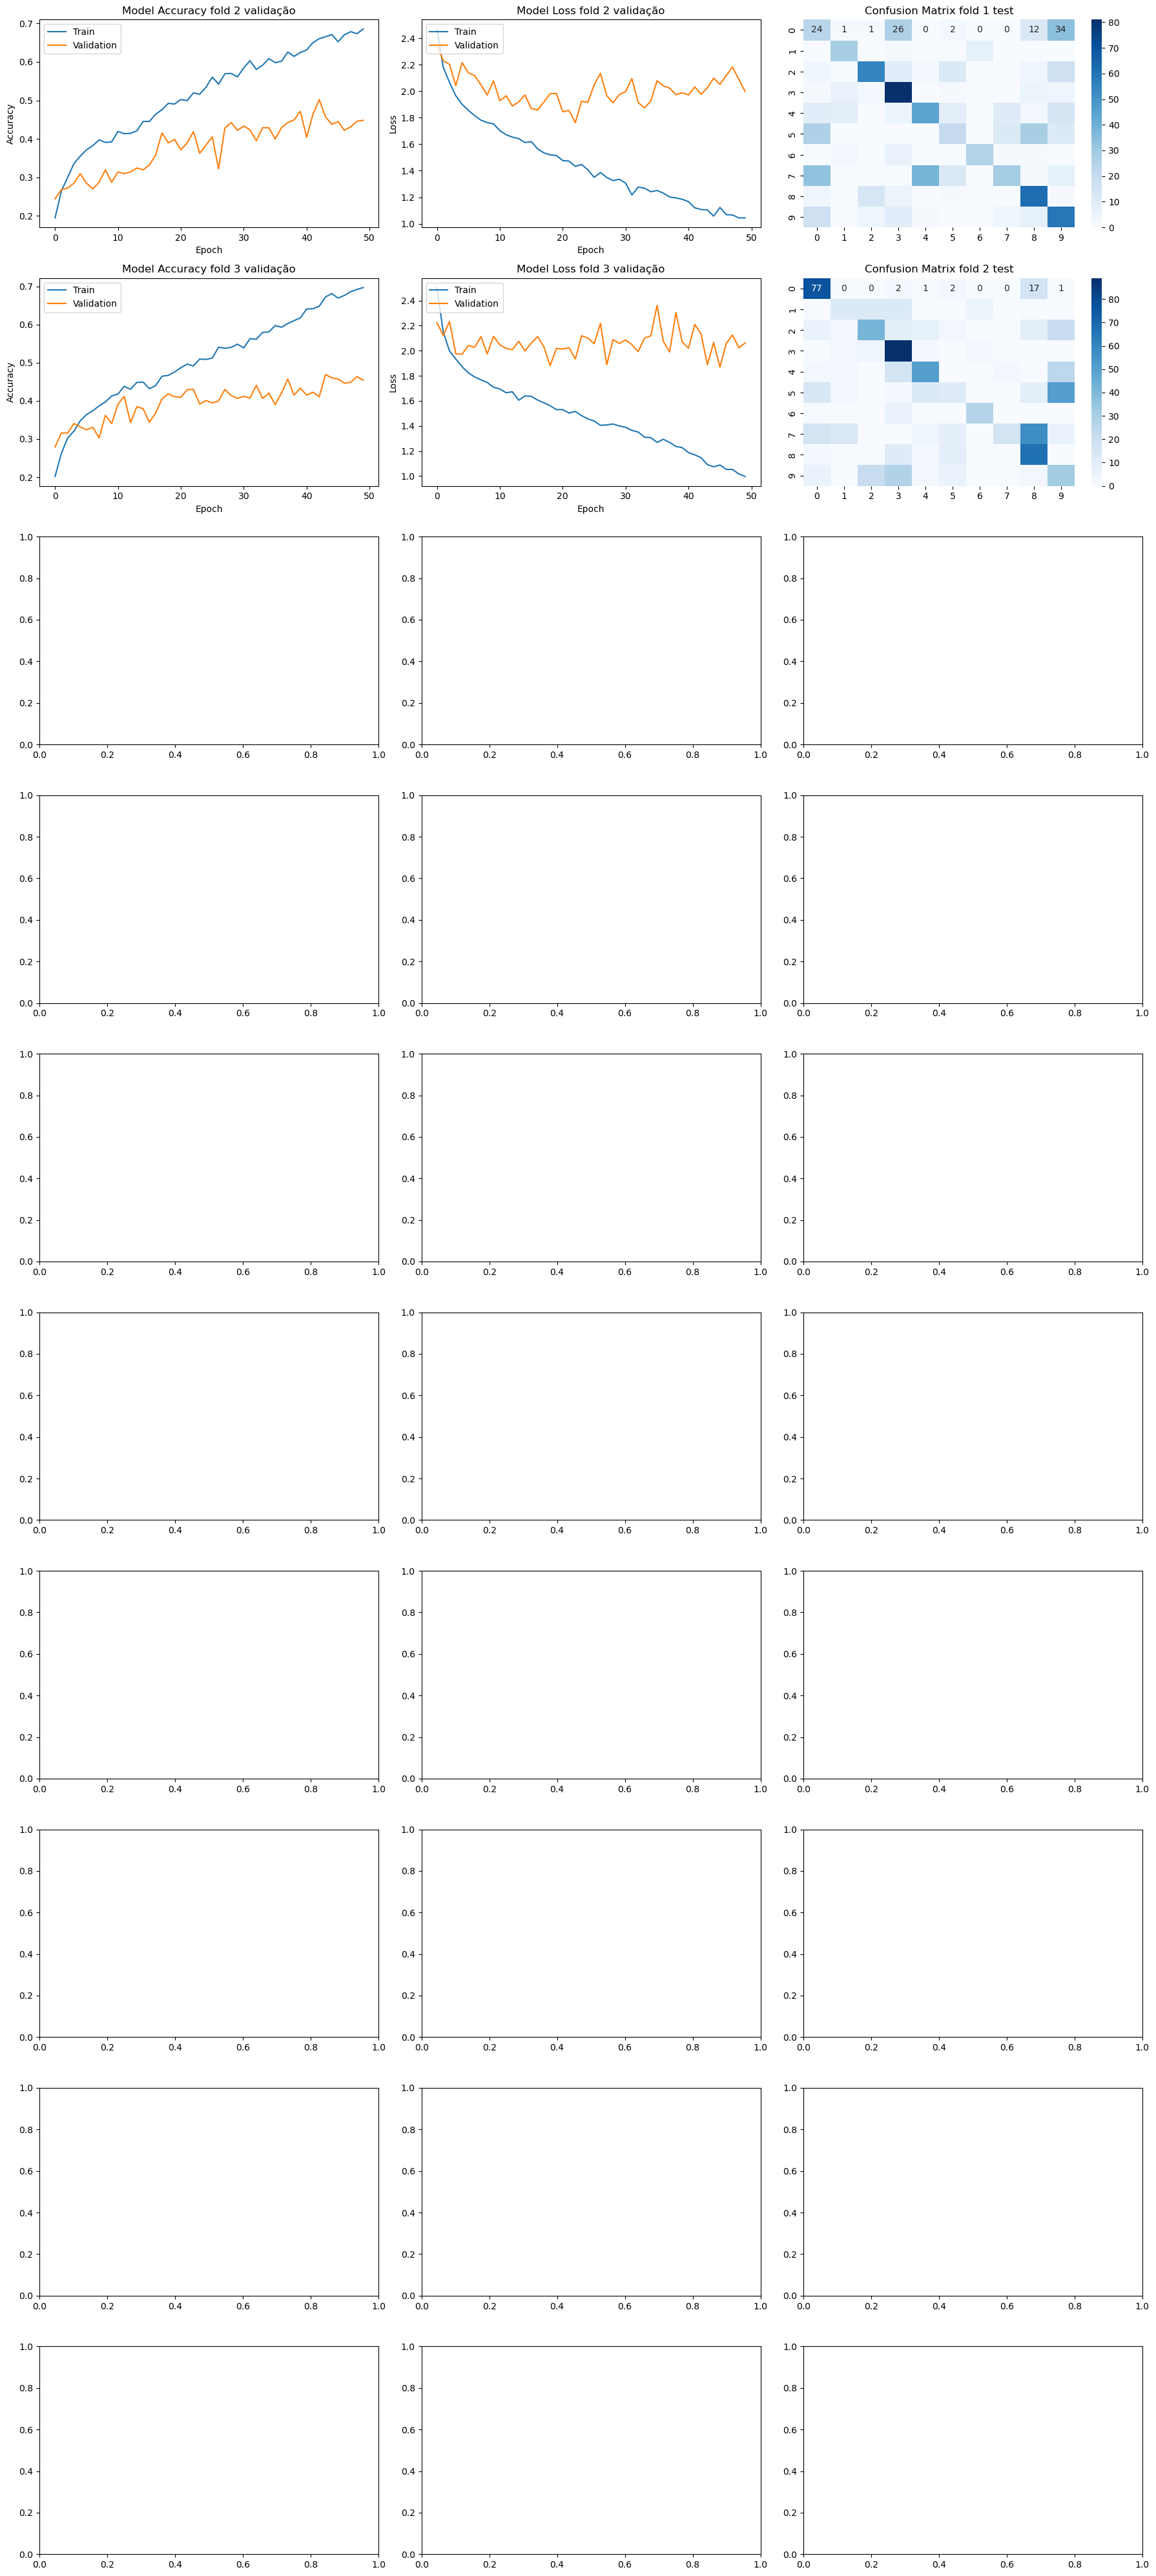

In [25]:
class_labels = [i for i in range(10)]
# Create a 10x3 grid for subplots
fig, axs = plt.subplots(10, 3, figsize=(18, 40))

for i in range(len(fold_metrics)):
    history = fold_metrics[i].get('history_dict')

    # Plot accuracy values
    axs[i,0].plot(history['accuracy'])
    axs[i,0].plot(history['val_accuracy'])
    if i == 9:
        axs[i,0].set_title(f'Model Accuracy fold 1 validação')
    else:    
        axs[i,0].set_title(f'Model Accuracy fold {i+2} validação')
    axs[i,0].set_ylabel('Accuracy')
    axs[i,0].set_xlabel('Epoch')
    axs[i,0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[i,1].plot(history['loss'])
    axs[i,1].plot(history['val_loss'])
    if i == 9:
        axs[i,1].set_title(f'Model Loss fold 1 validação')
    else:    
        axs[i,1].set_title(f'Model Loss fold {i+2} validação')
    axs[i,1].set_ylabel('Loss')
    axs[i,1].set_xlabel('Epoch')
    axs[i,1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = fold_metrics[i].get('confusion_matrix')
    axs[i,2].set_title(f'Confusion Matrix fold {i+1} test')
    axs[i,2].set_xlabel('Predicted')
    axs[i,2].set_ylabel('True')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[i,2])

# Adjust layout
plt.tight_layout()
plt.show()